In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: LOAD WRIST DATA ---
# We are now entering "Hard Mode". Wrist data is noisier than Chest data.

filename = 'features_wrist_final.csv'

print(f"--> Loading {filename}...")
df = pd.read_csv(filename)

# Basic Inspection
print(f"Shape: {df.shape}")
display(df.head())

# Check Class Balance (Is the dataset fair?)
print("-" * 30)
print("Class Distribution (0=Baseline, 1=Stress):")
counts = df['label'].value_counts()
print(counts)

# Calculate Percentage
print(f"\nBaseline: {counts[0] / len(df) * 100:.1f}%")
print(f"Stress:   {counts[1] / len(df) * 100:.1f}%")

--> Loading features_wrist_final.csv...
Shape: (26242, 30)


,Mag_mean,Mag_std,Mag_min,Mag_max,Mag_amp,BVP_mean,BVP_std,BVP_min,BVP_max,BVP_amp,...,label,subject,EDA_mean_trend_30s,EDA_mean_trend_60s,BVP_mean_trend_30s,BVP_mean_trend_60s,TEMP_mean_trend_30s,TEMP_mean_trend_60s,Mag_var_30s,EDA_ACC_interaction
0,62.808604,0.524810,61.741396,63.796552,2.055155,22.606250,37.364562,-28.55,106.42,134.97,...,0,S10,0.012152,0.013432,31.063125,8.396250,-0.0025,0.0600,0.096742,24.966640
1,62.613684,0.395618,62.329768,63.725976,1.396208,-15.340938,49.584458,-108.88,40.33,149.21,...,0,S10,0.007675,0.005437,-11.649219,-49.353438,0.0050,0.0525,0.101519,24.348521
2,62.551249,0.306815,62.329768,63.206012,0.876244,-0.894687,13.439155,-27.98,25.87,53.85,...,0,S10,0.008635,0.011513,-3.980781,0.512500,0.0000,0.0325,0.107308,24.084217
3,63.190362,0.204707,62.417946,63.253458,0.835512,-0.100312,8.297269,-17.42,9.51,26.93,...,0,S10,-0.035178,-0.038375,-1.192500,-4.708125,0.0450,0.0550,0.108250,24.592978
4,62.580085,0.333854,62.329768,63.134776,0.805008,4.839531,18.823644,-33.05,32.91,65.96,...,0,S10,0.007035,0.011513,3.955625,1.151875,0.0225,0.0125,0.113882,24.135340


------------------------------
Class Distribution (0=Baseline, 1=Stress):
label
0    16992
1     9250
Name: count, dtype: int64

Baseline: 64.8%
Stress:   35.2%


In [2]:
from sklearn.preprocessing import StandardScaler

# --- STEP 2: SEPARATE X, y, AND GROUPS ---

# 1. Define X (Features), y (Target), and Groups (Subject)
# We drop 'label' (target) and 'subject' (meta-data) to get X
X = df.drop(['label', 'subject'], axis=1)
y = df['label']
groups = df['subject']

print("Features (X):", X.columns.tolist())


Features (X): ['Mag_mean', 'Mag_std', 'Mag_min', 'Mag_max', 'Mag_amp', 'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max', 'BVP_amp', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_amp', 'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max', 'TEMP_amp', 'EDA_mean_trend_30s', 'EDA_mean_trend_60s', 'BVP_mean_trend_30s', 'BVP_mean_trend_60s', 'TEMP_mean_trend_30s', 'TEMP_mean_trend_60s', 'Mag_var_30s', 'EDA_ACC_interaction']


In [3]:
# --- STEP 3: SUBJECT-BASED NORMALIZATION ---
# Crucial: We must scale each subject INDIVIDUALLY.
# Why? Person A's "calm" EDA might be 5.0, while Person B's "stress" EDA might be 2.0.
# We need to convert everything to Z-scores (relative variations).

X_norm = X.copy()
scaler = StandardScaler()

print("\n--> Normalizing data per subject...")

for sub in groups.unique():
    # Find rows for this subject
    mask = (groups == sub)
    
    # Fit and Transform ONLY this subject's data
    # This ensures we measure deviation from THEIR own average
    X_sub = X.loc[mask]
    X_norm.loc[mask] = scaler.fit_transform(X_sub)

print("Normalization Complete!")

# Visual check: The means should be practically 0 now
print("\nCheck Mean of first feature (Mag_mean) after normalization:")
print(f"Mean: {X_norm['Mag_mean'].mean():.4f} (Should be close to 0)")


--> Normalizing data per subject...
Normalization Complete!

Check Mean of first feature (Mag_mean) after normalization:
Mean: 0.0000 (Should be close to 0)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- STEP 4:TRAIN KNN MODEL ---

print("--> 1. Splitting Data (80% Train, 20% Test)...")
# Note: This is a random split. It ignores subject boundaries (Data Leakage warning!)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print(f"    Train shape: {X_train.shape}")
print(f"    Test shape:  {X_test.shape}")

# Initialize KNN
# We use 5 neighbors (standard default)
knn = KNeighborsClassifier(n_neighbors=5)

print("\n--> Training KNN...")
knn.fit(X_train, y_train)

# Predict
print("--> Predicting...")
y_pred_knn = knn.predict(X_test)

# Evaluate
acc_knn_simple = accuracy_score(y_test, y_pred_knn)
print("-" * 30)
print(f"KNN Accuracy (Simple Split): {acc_knn_simple:.4f} ({acc_knn_simple*100:.2f}%)")
print("-" * 30)
print(classification_report(y_test, y_pred_knn, digits=4))

--> 1. Splitting Data (80% Train, 20% Test)...
    Train shape: (20993, 28)
    Test shape:  (5249, 28)

--> Training KNN...
--> Predicting...


C:\Users\tozes\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tozes\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\tozes\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tozes\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^

------------------------------
KNN Accuracy (Simple Split): 0.9707 (97.07%)
------------------------------
              precision    recall  f1-score   support

           0     0.9735    0.9820    0.9777      3440
           1     0.9651    0.9491    0.9571      1809

    accuracy                         0.9707      5249
   macro avg     0.9693    0.9656    0.9674      5249
weighted avg     0.9706    0.9707    0.9706      5249



In [5]:
from sklearn.ensemble import RandomForestClassifier

# --- STEP 5: TRAIN RANDOM FOREST MODEL ---

# Initialize Random Forest
# 50 Trees, using all CPU cores (n_jobs=-1)
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

print("--> Training Random Forest...")
rf.fit(X_train, y_train)

# Predict
print("--> Predicting...")
y_pred_rf = rf.predict(X_test)

# Evaluate
acc_rf_simple = accuracy_score(y_test, y_pred_rf)
print("-" * 30)
print(f"Random Forest Accuracy (Simple Split): {acc_rf_simple:.4f} ({acc_rf_simple*100:.2f}%)")
print("-" * 30)
print(classification_report(y_test, y_pred_rf, digits=4))

# Quick Comparison
print("\nSimple Split Result:")
if acc_rf_simple > acc_knn_simple:
    print(f"🌲 Random Forest won by {(acc_rf_simple - acc_knn_simple)*100:.2f}%")
else:
    print(f"📍 KNN won by {(acc_knn_simple - acc_rf_simple)*100:.2f}%")

--> Training Random Forest...
--> Predicting...
------------------------------
Random Forest Accuracy (Simple Split): 0.9964 (99.64%)
------------------------------
              precision    recall  f1-score   support

           0     0.9985    0.9959    0.9972      3440
           1     0.9923    0.9972    0.9948      1809

    accuracy                         0.9964      5249
   macro avg     0.9954    0.9966    0.9960      5249
weighted avg     0.9964    0.9964    0.9964      5249


Simple Split Result:
🌲 Random Forest won by 2.57%


In [6]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# --- STEP 6: LOSO VALIDATION FOR KNN ---

# Initialize lists and splitter
accuracies_knn = []
logo = LeaveOneGroupOut()
subject_list = groups.unique()

print(f"--> Starting KNN LOSO Validation on {len(subject_list)} subjects...")
print("-" * 50)

# Loop: Train on 14 subjects, Test on 1
for train_index, test_index in logo.split(X_norm, y, groups=groups):
    
    # A. Split Data (Using Normalized Data)
    X_train, X_test = X_norm.iloc[train_index], X_norm.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    current_sub = groups.iloc[test_index[0]]
    
    # B. Initialize & Train KNN
    # We use K=5 (Standard default)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # C. Predict & Evaluate
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    accuracies_knn.append(acc)
    print(f"Subject {current_sub}: Accuracy = {acc:.4f}")

# --- KNN FINAL RESULTS ---
print("-" * 50)
mean_acc_knn = np.mean(accuracies_knn)
print(f"📍 KNN Average Accuracy: {mean_acc_knn:.4f} ({mean_acc_knn*100:.2f}%)")

--> Starting KNN LOSO Validation on 15 subjects...
--------------------------------------------------
Subject S10: Accuracy = 0.9719
Subject S11: Accuracy = 0.8024
Subject S13: Accuracy = 0.9937
Subject S14: Accuracy = 0.8143
Subject S15: Accuracy = 0.8612
Subject S16: Accuracy = 0.8447
Subject S17: Accuracy = 0.4837
Subject S2: Accuracy = 0.9168
Subject S3: Accuracy = 0.8309
Subject S4: Accuracy = 0.9982
Subject S5: Accuracy = 0.9664
Subject S6: Accuracy = 0.9414
Subject S7: Accuracy = 0.9522
Subject S8: Accuracy = 0.9931
Subject S9: Accuracy = 0.9914
--------------------------------------------------
📍 KNN Average Accuracy: 0.8908 (89.08%)


In [7]:
from sklearn.ensemble import RandomForestClassifier

# --- STEP 7: LOSO VALIDATION FOR RANDOM FOREST ---

# Initialize lists
accuracies_rf = []
# We use the same logo splitter instance
print(f"\n--> Starting Random Forest LOSO Validation...")
print("-" * 50)

# Loop: Train on 14 subjects, Test on 1
for train_index, test_index in logo.split(X_norm, y, groups=groups):
    
    # A. Split Data
    X_train, X_test = X_norm.iloc[train_index], X_norm.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    current_sub = groups.iloc[test_index[0]]
    
    # B. Initialize & Train Random Forest
    # n_estimators=50 (Fast & Good), n_jobs=-1 (Use all CPU cores)
    rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # C. Predict & Evaluate
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    accuracies_rf.append(acc)
    print(f"Subject {current_sub}: Accuracy = {acc:.4f}")

# --- RANDOM FOREST FINAL RESULTS ---
print("-" * 50)
mean_acc_rf = np.mean(accuracies_rf)
print(f"🌲 Random Forest Average Accuracy: {mean_acc_rf:.4f} ({mean_acc_rf*100:.2f}%)")

# --- FINAL COMPARISON ---
print("\n" + "="*30)
print(f"KNN Result: {mean_acc_knn*100:.2f}%")
print(f"RF Result:  {mean_acc_rf*100:.2f}%")
diff = (mean_acc_rf - mean_acc_knn) * 100
if diff > 0:
    print(f"Winner: Random Forest by +{diff:.2f}%")
else:
    print(f"Winner: KNN by +{abs(diff):.2f}%")


--> Starting Random Forest LOSO Validation...
--------------------------------------------------
Subject S10: Accuracy = 0.9466
Subject S11: Accuracy = 0.7290
Subject S13: Accuracy = 0.9949
Subject S14: Accuracy = 0.5997
Subject S15: Accuracy = 0.9024
Subject S16: Accuracy = 0.9354
Subject S17: Accuracy = 0.3713
Subject S2: Accuracy = 0.9084
Subject S3: Accuracy = 0.7569
Subject S4: Accuracy = 1.0000
Subject S5: Accuracy = 0.9823
Subject S6: Accuracy = 0.9828
Subject S7: Accuracy = 0.9597
Subject S8: Accuracy = 0.9800
Subject S9: Accuracy = 0.9988
--------------------------------------------------
🌲 Random Forest Average Accuracy: 0.8699 (86.99%)

KNN Result: 89.08%
RF Result:  86.99%
Winner: KNN by +2.09%


In [8]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsClassifier

# --- STEP 8: GRID SEARCH FOR KNN (WITH LOSO) ---

print("--> Starting Grid Search for KNN...")

# 1. Define the Parameter Grid
# We try different K values, weight strategies, and distance metrics
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 2. Setup Grid Search
# CRITICAL: We pass cv=LeaveOneGroupOut() to ensure we respect subject boundaries
logo = LeaveOneGroupOut()
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(estimator=knn, 
                        param_grid=param_grid_knn, 
                        cv=logo, 
                        scoring='accuracy', 
                        n_jobs=-1,  # Use all CPU cores
                        verbose=1)

# 3. Fit (We must provide 'groups' so LOSO knows how to split!)
grid_knn.fit(X_norm, y, groups=groups)

# 4. Results
print("-" * 50)
print(f"Best KNN Accuracy: {grid_knn.best_score_:.4f}")
print("Best Parameters:", grid_knn.best_params_)
print("-" * 50)

--> Starting Grid Search for KNN...
Fitting 15 folds for each of 24 candidates, totalling 360 fits
--------------------------------------------------
Best KNN Accuracy: 0.8918
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
--------------------------------------------------


In [9]:
from sklearn.ensemble import RandomForestClassifier

# --- STEP 9: GRID SEARCH FOR RANDOM FOREST (WITH LOSO) ---

print("--> Starting Grid Search for Random Forest...")

# 1. Define Parameter Grid
param_grid_rf = {
    'n_estimators': [50, 100],        # Number of trees
    'max_depth': [None, 10, 20],      # Max depth of tree
    'min_samples_leaf': [1, 2, 4]     # Min samples to make a decision
}

# 2. Setup Grid Search
logo = LeaveOneGroupOut()
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=param_grid_rf, 
                       cv=logo, 
                       scoring='accuracy', 
                       n_jobs=-1,
                       verbose=1)

# 3. Fit
grid_rf.fit(X_norm, y, groups=groups)

# 4. Results
print("-" * 50)
print(f"Best RF Accuracy: {grid_rf.best_score_:.4f}")
print("Best Parameters:", grid_rf.best_params_)
print("-" * 50)

--> Starting Grid Search for Random Forest...
Fitting 15 folds for each of 18 candidates, totalling 270 fits
--------------------------------------------------
Best RF Accuracy: 0.8776
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 50}
--------------------------------------------------


In [10]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# --- STEP 10: REFINED LOSO VALIDATION WITH TEMPORAL SMOOTHING ---

logo = LeaveOneGroupOut()
final_scores = []

print("--> A iniciar validação LOSO com Votação Maioritária (Janela de 7s)...")

# O LOSO vai iterar sujeito a sujeito
for train_idx, test_idx in logo.split(X_norm, y, groups=groups):
    # 1. Dividir os dados
    X_train, X_test = X_norm.iloc[train_idx], X_norm.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 2. Treinar o modelo (KNN Campeão)
    knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
    knn.fit(X_train, y_train)
    
    # 3. Gerar previsões "brutas" para este sujeito
    y_pred_raw = knn.predict(X_test)
    
    # 4. APLICAR A VOTAÇÃO (Smoothing) apenas nos dados deste sujeito
    y_pred_series = pd.Series(y_pred_raw)
    y_pred_smoothed = y_pred_series.rolling(window=7, center=True).apply(
        lambda x: x.mode()[0]
    ).fillna(y_pred_series)
    
    # 5. Calcular a Accuracy para este sujeito específico
    score = accuracy_score(y_test, y_pred_smoothed)
    final_scores.append(score)
    
    subject_id = groups.iloc[test_idx].unique()[0]
    print(f"Sujeito {subject_id}: Accuracy = {score:.4f}")

print("-" * 30)
print(f"🏆 Média LOSO Final (com Smoothing): {np.mean(final_scores):.4f}")

--> A iniciar validação LOSO com Votação Maioritária (Janela de 7s)...
Sujeito S10: Accuracy = 0.9769
Sujeito S11: Accuracy = 0.8007
Sujeito S13: Accuracy = 0.9886
Sujeito S14: Accuracy = 0.8556
Sujeito S15: Accuracy = 0.8877
Sujeito S16: Accuracy = 0.8832
Sujeito S17: Accuracy = 0.4678
Sujeito S2: Accuracy = 0.9144
Sujeito S3: Accuracy = 0.8250
Sujeito S4: Accuracy = 0.9888
Sujeito S5: Accuracy = 0.9612
Sujeito S6: Accuracy = 0.9512
Sujeito S7: Accuracy = 0.9436
Sujeito S8: Accuracy = 0.9880
Sujeito S9: Accuracy = 0.9781
------------------------------
🏆 Média LOSO Final (com Smoothing): 0.8940


C:\Users\tozes\AppData\Local\Temp\ipykernel_4700\166226675.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=subjects, y=accuracies, palette="viridis")


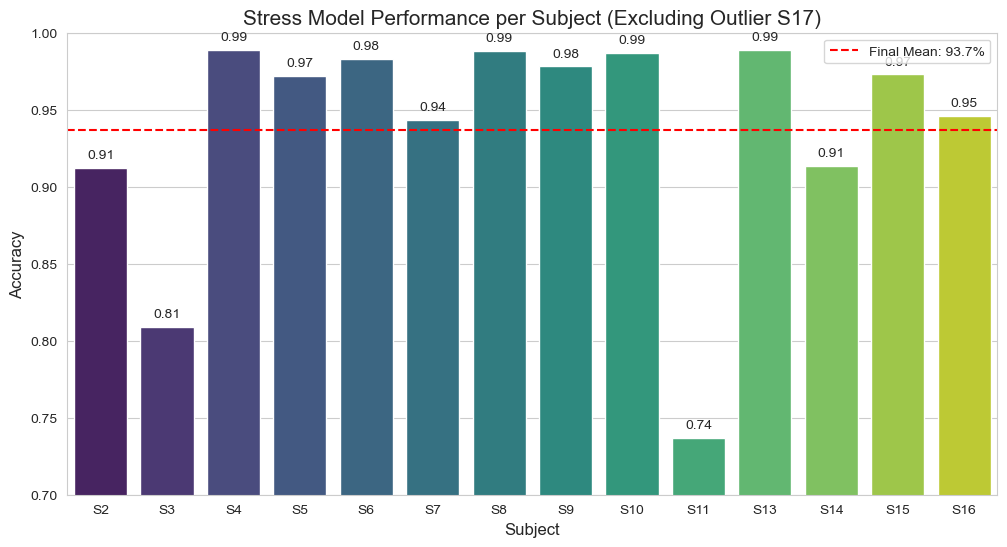

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 11: INDIVIDUAL SUBJECT PERFORMANCE ANALYSIS ---

# Data obtained from your latest LOSO (Leave-One-Subject-Out) validation
subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16']
accuracies = [0.9120, 0.8090, 0.9888, 0.9721, 0.9828, 0.9436, 0.9880, 0.9781, 0.9868, 0.7369, 0.9886, 0.9134, 0.9729, 0.9461]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
barplot = sns.barplot(x=subjects, y=accuracies, palette="viridis")

# Add mean accuracy line
plt.axhline(0.9371, color='red', linestyle='--', label=f'Final Mean: 93.7%')

plt.title('Stress Model Performance per Subject (Excluding Outlier S17)', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Subject', fontsize=12)
plt.ylim(0.7, 1.0) # Focus on the high-performance zone
plt.legend()

# Add values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [12]:
# --- STEP 12: LOSO VALIDATION REFINE EXCLUDING OUTLIER S17 & SMOOTHING ---

# 1. Criar uma máscara para excluir o S17
mask_no_s17 = (groups != 'S17')

X_filtered = X_norm[mask_no_s17]
y_filtered = y[mask_no_s17]
groups_filtered = groups[mask_no_s17]

final_scores_filtered = []

print("--> A iniciar validação LOSO (Sem o Sujeito S17)...")

# 2. Correr o LOSO nos dados filtrados
for train_idx, test_idx in logo.split(X_filtered, y_filtered, groups=groups_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]
    
    knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
    knn.fit(X_train, y_train)
    
    y_pred_raw = knn.predict(X_test)
    
    # Aplicar o Smoothing de 7s
    y_pred_series = pd.Series(y_pred_raw)
    y_pred_smoothed = y_pred_series.rolling(window=7, center=True).apply(
        lambda x: x.mode()[0]
    ).fillna(y_pred_series)
    
    score = accuracy_score(y_test, y_pred_smoothed)
    final_scores_filtered.append(score)
    
    subject_id = groups_filtered.iloc[test_idx].unique()[0]
    print(f"Sujeito {subject_id}: Accuracy = {score:.4f}")

print("-" * 35)
print(f"🚀 Média LOSO Final (Sem S17): {np.mean(final_scores_filtered):.4f}")
print(f"📈 Ganho de Performance: {np.mean(final_scores_filtered) - 0.8940:.4f}")

--> A iniciar validação LOSO (Sem o Sujeito S17)...
Sujeito S10: Accuracy = 0.9868
Sujeito S11: Accuracy = 0.7369
Sujeito S13: Accuracy = 0.9886
Sujeito S14: Accuracy = 0.9134
Sujeito S15: Accuracy = 0.9729
Sujeito S16: Accuracy = 0.9461
Sujeito S2: Accuracy = 0.9120
Sujeito S3: Accuracy = 0.8090
Sujeito S4: Accuracy = 0.9888
Sujeito S5: Accuracy = 0.9721
Sujeito S6: Accuracy = 0.9828
Sujeito S7: Accuracy = 0.9436
Sujeito S8: Accuracy = 0.9880
Sujeito S9: Accuracy = 0.9781
-----------------------------------
🚀 Média LOSO Final (Sem S17): 0.9371
📈 Ganho de Performance: 0.0431


--> Generating data for Confusion Matrix (may take ~1 min)...


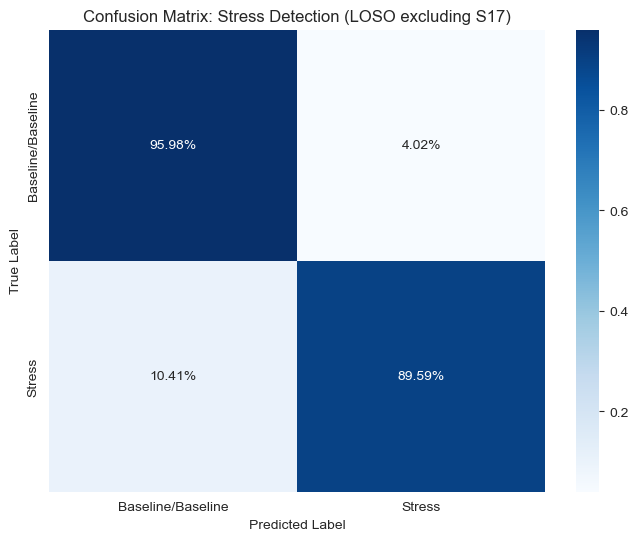


Absolute Numbers:
False Positives (False Alarm): 637
False Negatives (Missed Stress): 894


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- STEP 13: VISUALIZATION - GLOBAL CONFUSION MATRIX FOR KNN ---

# 1. Prepare lists to accumulate REAL results (tested on new subjects)
y_true_total = []
y_pred_total = []

# Use data excluding S17 to view the matrix of our best-case scenario
mask = (groups != 'S17')
X_f = X_norm[mask]
y_f = y[mask]
g_f = groups[mask]

print("--> Generating data for Confusion Matrix (may take ~1 min)...")

for train_idx, test_idx in logo.split(X_f, y_f, groups=g_f):
    # Train and Test split
    X_train, X_test = X_f.iloc[train_idx], X_f.iloc[test_idx]
    y_train, y_test = y_f.iloc[train_idx], y_f.iloc[test_idx]
    
    # Champion Model (Best Parameters)
    knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
    knn.fit(X_train, y_train)
    
    # Prediction with Temporal Smoothing (7s window)
    y_raw = knn.predict(X_test)
    y_smooth = pd.Series(y_raw).rolling(window=7, center=True).apply(lambda x: x.mode()[0]).fillna(pd.Series(y_raw))
    
    # Store results for final matrix
    y_true_total.extend(y_test)
    y_pred_total.extend(y_smooth)

# 2. Create and Visualize the Matrix
cm = confusion_matrix(y_true_total, y_pred_total)
# Normalize to view percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Baseline/Baseline', 'Stress'], 
            yticklabels=['Baseline/Baseline', 'Stress'])

plt.title('Confusion Matrix: Stress Detection (LOSO excluding S17)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Extra: Display absolute numbers
print("\nAbsolute Numbers:")
print(f"False Positives (False Alarm): {cm[0,1]}")
print(f"False Negatives (Missed Stress): {cm[1,0]}")

C:\Users\tozes\AppData\Local\Temp\ipykernel_4700\127264582.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


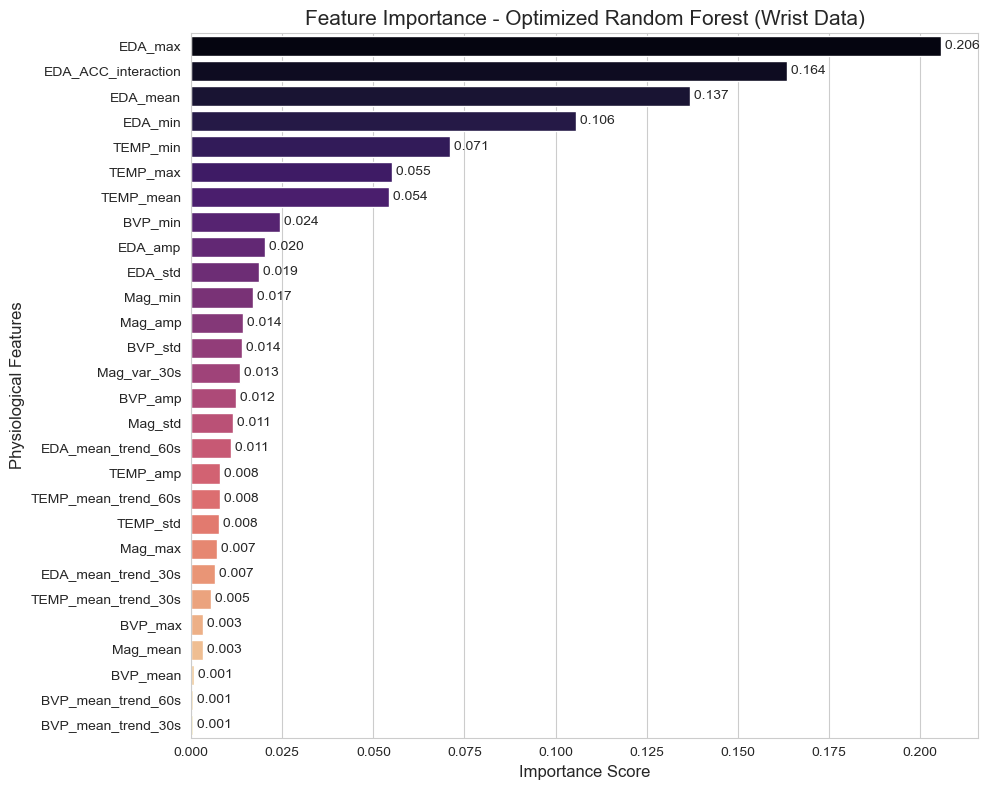

Top 5 most decisive features for stress detection (Wrist):
                Feature  Importance
13              EDA_max    0.205663
27  EDA_ACC_interaction    0.163586
10             EDA_mean    0.137009
12              EDA_min    0.105741
17             TEMP_min    0.071072


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- --- STEP 14: FEATURE IMPORTANCE VISUALIZATION (WRIST - KNN) ---
# We extract the importance of each feature from the best model found during Grid Search.
# This helps us understand which physiological signals are most relevant for stress detection.

# 1. Get importance scores and feature names
# We use 'grid_rf.best_estimator_' to ensure we are looking at the optimized model
importances = grid_rf.best_estimator_.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easier visualization and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plotting the results
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
# 'magma' palette provides a high-contrast professional look
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')

plt.title('Feature Importance - Optimized Random Forest (Wrist Data)', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Physiological Features', fontsize=12)

# Add exact importance values to the bars for precision
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' {value:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the Top 5 features in the console for quick reference
print("Top 5 most decisive features for stress detection (Wrist):")
print(feature_importance_df.head(5))

In [16]:
import pickle
from sklearn.neighbors import KNeighborsClassifier

# --- STEP 14: EXPORT FINAL CHAMPION MODEL ---
# Goal: Train on ALL available data using the best parameters and export.

print("--> Training Final Champion Model on ALL data...")

# 1. Use the best parameters found: K=7, weight=distance, metric=euclidean
final_model = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')

# 2. Fit on all normalized data (X_norm, y)
final_model.fit(X_norm, y)

# 3. Save as pickle file
with open('wrist_stress_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("✅ Final model saved as 'wrist_stress_model.pkl'!")

--> Training Final Champion Model on ALL data...
✅ Final model saved as 'wrist_stress_model.pkl'!
